<a href="https://colab.research.google.com/github/NIDHIMLVR/Bharathnatyam-Mudra-Detector/blob/main/Bharathnatyam_Mudra_Classifier_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
import zipfile
import os
uploaded = files.upload()  # upload e.g. "cvzip.zip"
with zipfile.ZipFile("cvzip.zip", 'r') as zip_ref:
    zip_ref.extractall("cvdataset")
# Path to original dataset
original_dir = "cvdataset/cvassignmentdataset - Copy"
split_base_dir = "cvdataset_split"
import shutil
import numpy as np
from sklearn.model_selection import train_test_split
# Split ratios
train_ratio = 0.8  #training
val_ratio = 0.1  #validation
test_ratio = 0.1 #testing
# Create base folders
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(split_base_dir, split), exist_ok=True)
# Go through each class
for class_name in os.listdir(original_dir):
    class_path = os.path.join(original_dir, class_name)
    if not os.path.isdir(class_path):
        continue
    images = [img for img in os.listdir(class_path) if img.lower().endswith(('.jpg', '.png', '.jpeg'))]
    train_imgs, temp_imgs = train_test_split(images, train_size=train_ratio, random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=test_ratio/(val_ratio + test_ratio), random_state=42)
    for split, split_imgs in zip(['train', 'val', 'test'], [train_imgs, val_imgs, test_imgs]):
        split_dir = os.path.join(split_base_dir, split, class_name)
        os.makedirs(split_dir, exist_ok=True)
        for img in split_imgs:
            shutil.copy2(os.path.join(class_path, img), os.path.join(split_dir, img))

Saving cvzip.zip to cvzip.zip


In [ ]:
pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 92.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 19.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
ydf 0.12.0 requires protobuf<6.0.0,>=5.29.1, but you have protobuf 4.25.8 which is incompatible.
grpcio-

In [ ]:
import os
import cv2
import mediapipe as mp
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

# === Step 1: Extract keypoints from cvdataset_split ===

base_dir = "cvdataset_split"
splits = ['train', 'val', 'test']  # We'll use all splits for MLP training
data = []
labels = []

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1)

for split in splits:
    split_dir = os.path.join(base_dir, split)
    for label in os.listdir(split_dir):
        class_dir = os.path.join(split_dir, label)
        for file in os.listdir(class_dir):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(class_dir, file)
                image = cv2.imread(img_path)
                if image is None:
                    continue
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                results = hands.process(image_rgb)

                if results.multi_hand_landmarks:
                    landmarks = results.multi_hand_landmarks[0]
                    row = []
                    for lm in landmarks.landmark:
                        row.extend([lm.x, lm.y, lm.z])  # 21 keypoints × 3 = 63
                    data.append(row)
                    labels.append(label)

hands.close()

# Convert to DataFrame
df = pd.DataFrame(data)
df['label'] = labels
df.to_csv("hand_landmark_dataset.csv", index=False)
print("Saved hand_landmark_dataset.csv")

# === Step 2: Train MLP model ===

X = df.drop('label', axis=1).values
y = LabelEncoder().fit_transform(df['label'])
y_cat = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)

model = Sequential([
    Dense(128, activation='relu', input_shape=(63,)),
    Dense(64, activation='relu'),
    Dense(len(np.unique(y)), activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32
)

model.save('new_hand_landmark_classifier.h5')
print("Saved model to new_hand_landmark_classifier.h5")


Saved hand_landmark_dataset.csv
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.2696 - loss: 1.5920 - val_accuracy: 0.4347 - val_loss: 1.5207
Epoch 2/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4220 - loss: 1.4918 - val_accuracy: 0.4073 - val_loss: 1.4074
Epoch 3/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4720 - loss: 1.3870 - val_accuracy: 0.4924 - val_loss: 1.2729
Epoch 4/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5342 - loss: 1.2144 - val_accuracy: 0.6413 - val_loss: 1.1332
Epoch 5/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6190 - loss: 1.0994 - val_accuracy: 0.6231 - val_loss: 1.0252
Epoch 6/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6295 - loss: 1.0030 - val_accuracy: 0.6626 - val_loss: 0.9241
Epoch 7/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6675 - loss: 0.9093 - val_accuracy: 0.6687 - val_loss: 0.8845
Epoch 8/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6777 - loss: 0.8439 - val_accuracy: 0.6991 - val_loss: 0.7940
Ep

Saved model to new_hand_landmark_classifier.h5


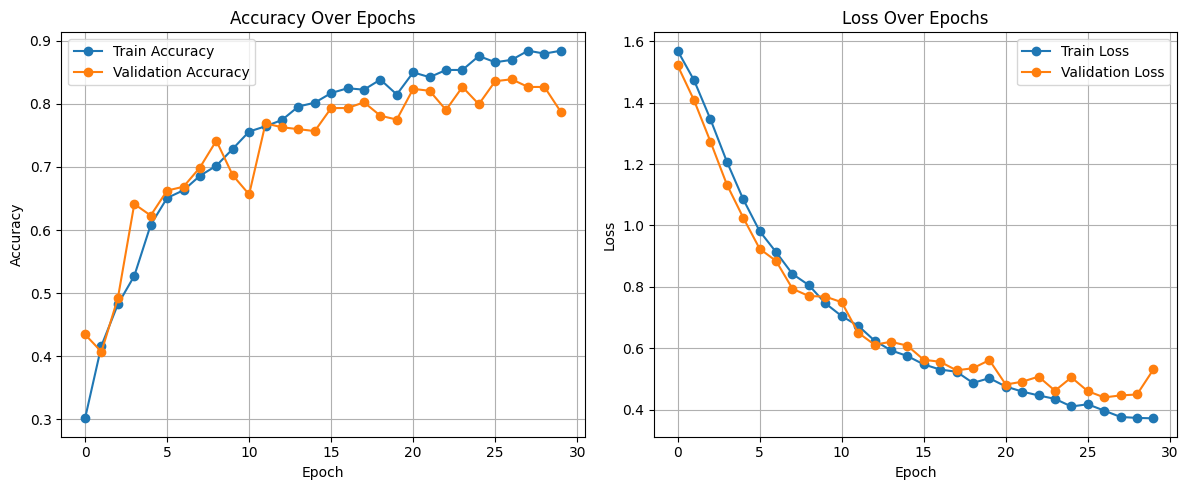

In [ ]:
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
import os
import cv2
import numpy as np
import mediapipe as mp
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# === Load model and initialize ===
model = load_model('new_hand_landmark_classifier.h5')
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1)

# === Load test data ===
test_dir = "cvdataset_split/test"
true_labels = []
pred_labels = []

# Prepare label encoder (must match training)
class_names = sorted(os.listdir(test_dir))
le = LabelEncoder()
le.fit(class_names)

for label in class_names:
    class_path = os.path.join(test_dir, label)
    for file in os.listdir(class_path):
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(class_path, file)
            image = cv2.imread(img_path)
            if image is None:
                continue
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            result = hands.process(image_rgb)

            if result.multi_hand_landmarks:
                hand = result.multi_hand_landmarks[0]
                keypoints = []
                for lm in hand.landmark:
                    keypoints.extend([lm.x, lm.y, lm.z])

                keypoints = np.array(keypoints).reshape(1, -1)
                preds = model.predict(keypoints)
                pred_index = np.argmax(preds)

                pred_label = le.inverse_transform([pred_index])[0]
                pred_labels.append(pred_label)
                true_labels.append(label)

hands.close()




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━


Classification Report:
              precision    recall  f1-score   support

Ardhapathaka       0.93      0.78      0.85        32
Kartarimukha       1.00      0.86      0.92        35
      Mayura       0.85      0.90      0.88        31
     Pathaka       0.77      0.94      0.85        35
  Tripathaka       0.65      0.65      0.65        31

    accuracy                           0.83       164
   macro avg       0.84      0.83      0.83       164
weighted avg       0.84      0.83      0.83       164



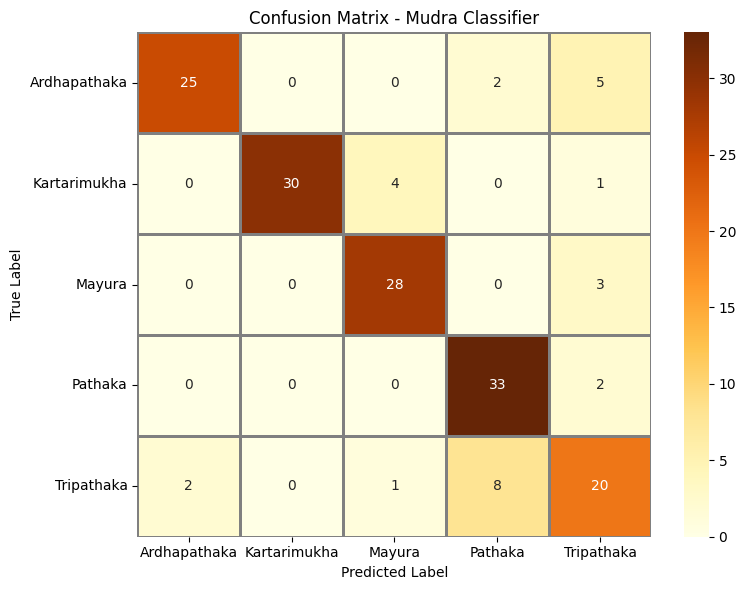

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# === Evaluation ===
print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)

# Display heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrBr',
            xticklabels=class_names, yticklabels=class_names,
            linewidths=1, linecolor='gray', cbar=True)

plt.title('Confusion Matrix - Mudra Classifier')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()


In [ ]:
from google.colab import files
files.download('new_hand_landmark_classifier.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>